In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import io
train_df = pd.read_csv('/content/staff_present_2015_2021_realistic.csv')
test_df = pd.read_csv('/content/staff_present_2022_2023_realistic.csv')
event_df = pd.read_csv('/content/public_holidays.csv')
train_df = train_df.dropna(subset=['Present'])
print(train_df['Present'])


Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 79.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.
0       11
1       67
2       14
3        0
4       99
        ..
2552    59
2553    28
2554    94
2555    70
2556    24
Name: Present, Length: 2557, dtype: int64


In [ ]:
# Step 3: Preprocessing Data
# Convert 'date' columns to datetime
def create_date_dataframe(start_date, num_months):
    start_date = pd.to_datetime(start_date)  # Convert start_date to datetime
    end_date = start_date + pd.DateOffset(months=num_months)  # Calculate end date
    dates = pd.date_range(start=start_date, end=end_date, freq='D')  # Generate date range
    df = pd.DataFrame({'Date': dates})  # Create DataFrame
    return df


def pre_process_data(date_df,event_df=event_df):
 date_df['Date'] = pd.to_datetime(date_df['Date'], format='%Y-%m-%d')
 event_df['Date'] = pd.to_datetime(event_df['Date'], format='%Y-%m-%d')
# Extract more date-related features
 date_df['day_of_week'] = date_df['Date'].dt.dayofweek
 date_df['month'] = date_df['Date'].dt.month
 date_df['day'] = date_df['Date'].dt.day
 date_df['weekofyear'] = date_df['Date'].dt.isocalendar().week
 date_df['quarter'] = date_df['Date'].dt.quarter
 date_df['is_weekend'] = date_df['day_of_week'].isin([5, 6]).astype(int)
 date_df['is_month_start'] = date_df['Date'].dt.is_month_start.astype(int)
 date_df['is_month_end'] = date_df['Date'].dt.is_month_end.astype(int)
 date_df['is_holiday'] = (date_df['Date'].isin(event_df['Date'])).astype(int)
 date_df['is_next_holiday'] = (date_df['Date'].isin(event_df['Date'] + pd.Timedelta(days=1))).astype(int)
 date_df['is_prev_holiday'] = (date_df['Date'].isin(event_df['Date'] - pd.Timedelta(days=1))).astype(int)
 date_df['is_sunday'] = (date_df['day_of_week'] == 6).astype(int)
 date_df["Total"] = date_df.apply(lambda row: 0 if row["is_holiday"] == 1 or row["day_of_week"] == 6 else 100, axis=1)
pre_process_data(train_df)
pre_process_data(test_df)
# Step 5: Feature Engineering
# Select features and target variable
features = ['day_of_week', 'month', 'day', 'weekofyear', 'quarter', 'is_weekend', 'is_month_start', 'is_month_end', 'is_holiday','is_next_holiday','is_prev_holiday',"is_sunday"]
X_train = train_df[features]
y_train = train_df['Present']
X_val=test_df[features]
y_val=test_df['Present']


# Step 7: Hyperparameter Tuning with GridSearchCV (Optional)
param_grid = {
    'n_estimators': [80],
    'max_depth': [3],
    'learning_rate': [0.8],
    'subsample': [ 0.4],
    'colsample_bytree': [1.0]
}

xgb_model = XGBRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train,y_train)

# Best parameters from the grid search
best_params = grid_search.best_params_
print(best_params)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'colsample_bytree': 1.0, 'learning_rate': 0.8, 'max_depth': 3, 'n_estimators': 80, 'subsample': 0.4}


In [ ]:

xgb_model = XGBRegressor(random_state=42, **best_params)
xgb_model.fit(X_train, y_train)
test_dfn = test_df[~((test_df['is_holiday'] == 1) | (test_df['day_of_week'] == 6))]
test_predictions = xgb_model.predict(test_df[features])
test_predictions = np.where(test_predictions < 0, 0, test_predictions)
submission = pd.DataFrame({
    'Date': test_df['Date'],
    'Present': test_predictions.astype(int)
})
print(submission)
# Replace NaN values in 'present' column of test_df with 0 (or any other suitable value)
test_df['Present'] = test_df['Present'].fillna(0)

# ... (rest of the code) ...
#Recalculate y_val
y_val=test_df['Present']
rmse=np.sqrt(mean_squared_error(y_val,test_predictions))
print(rmse)

          Date  Present
0   2022-01-01        0
1   2022-01-02       26
2   2022-01-03       76
3   2022-01-04       70
4   2022-01-05       69
..         ...      ...
725 2023-12-27       67
726 2023-12-28       83
727 2023-12-29       81
728 2023-12-30       28
729 2023-12-31        0

[726 rows x 2 columns]
21.398490486870443


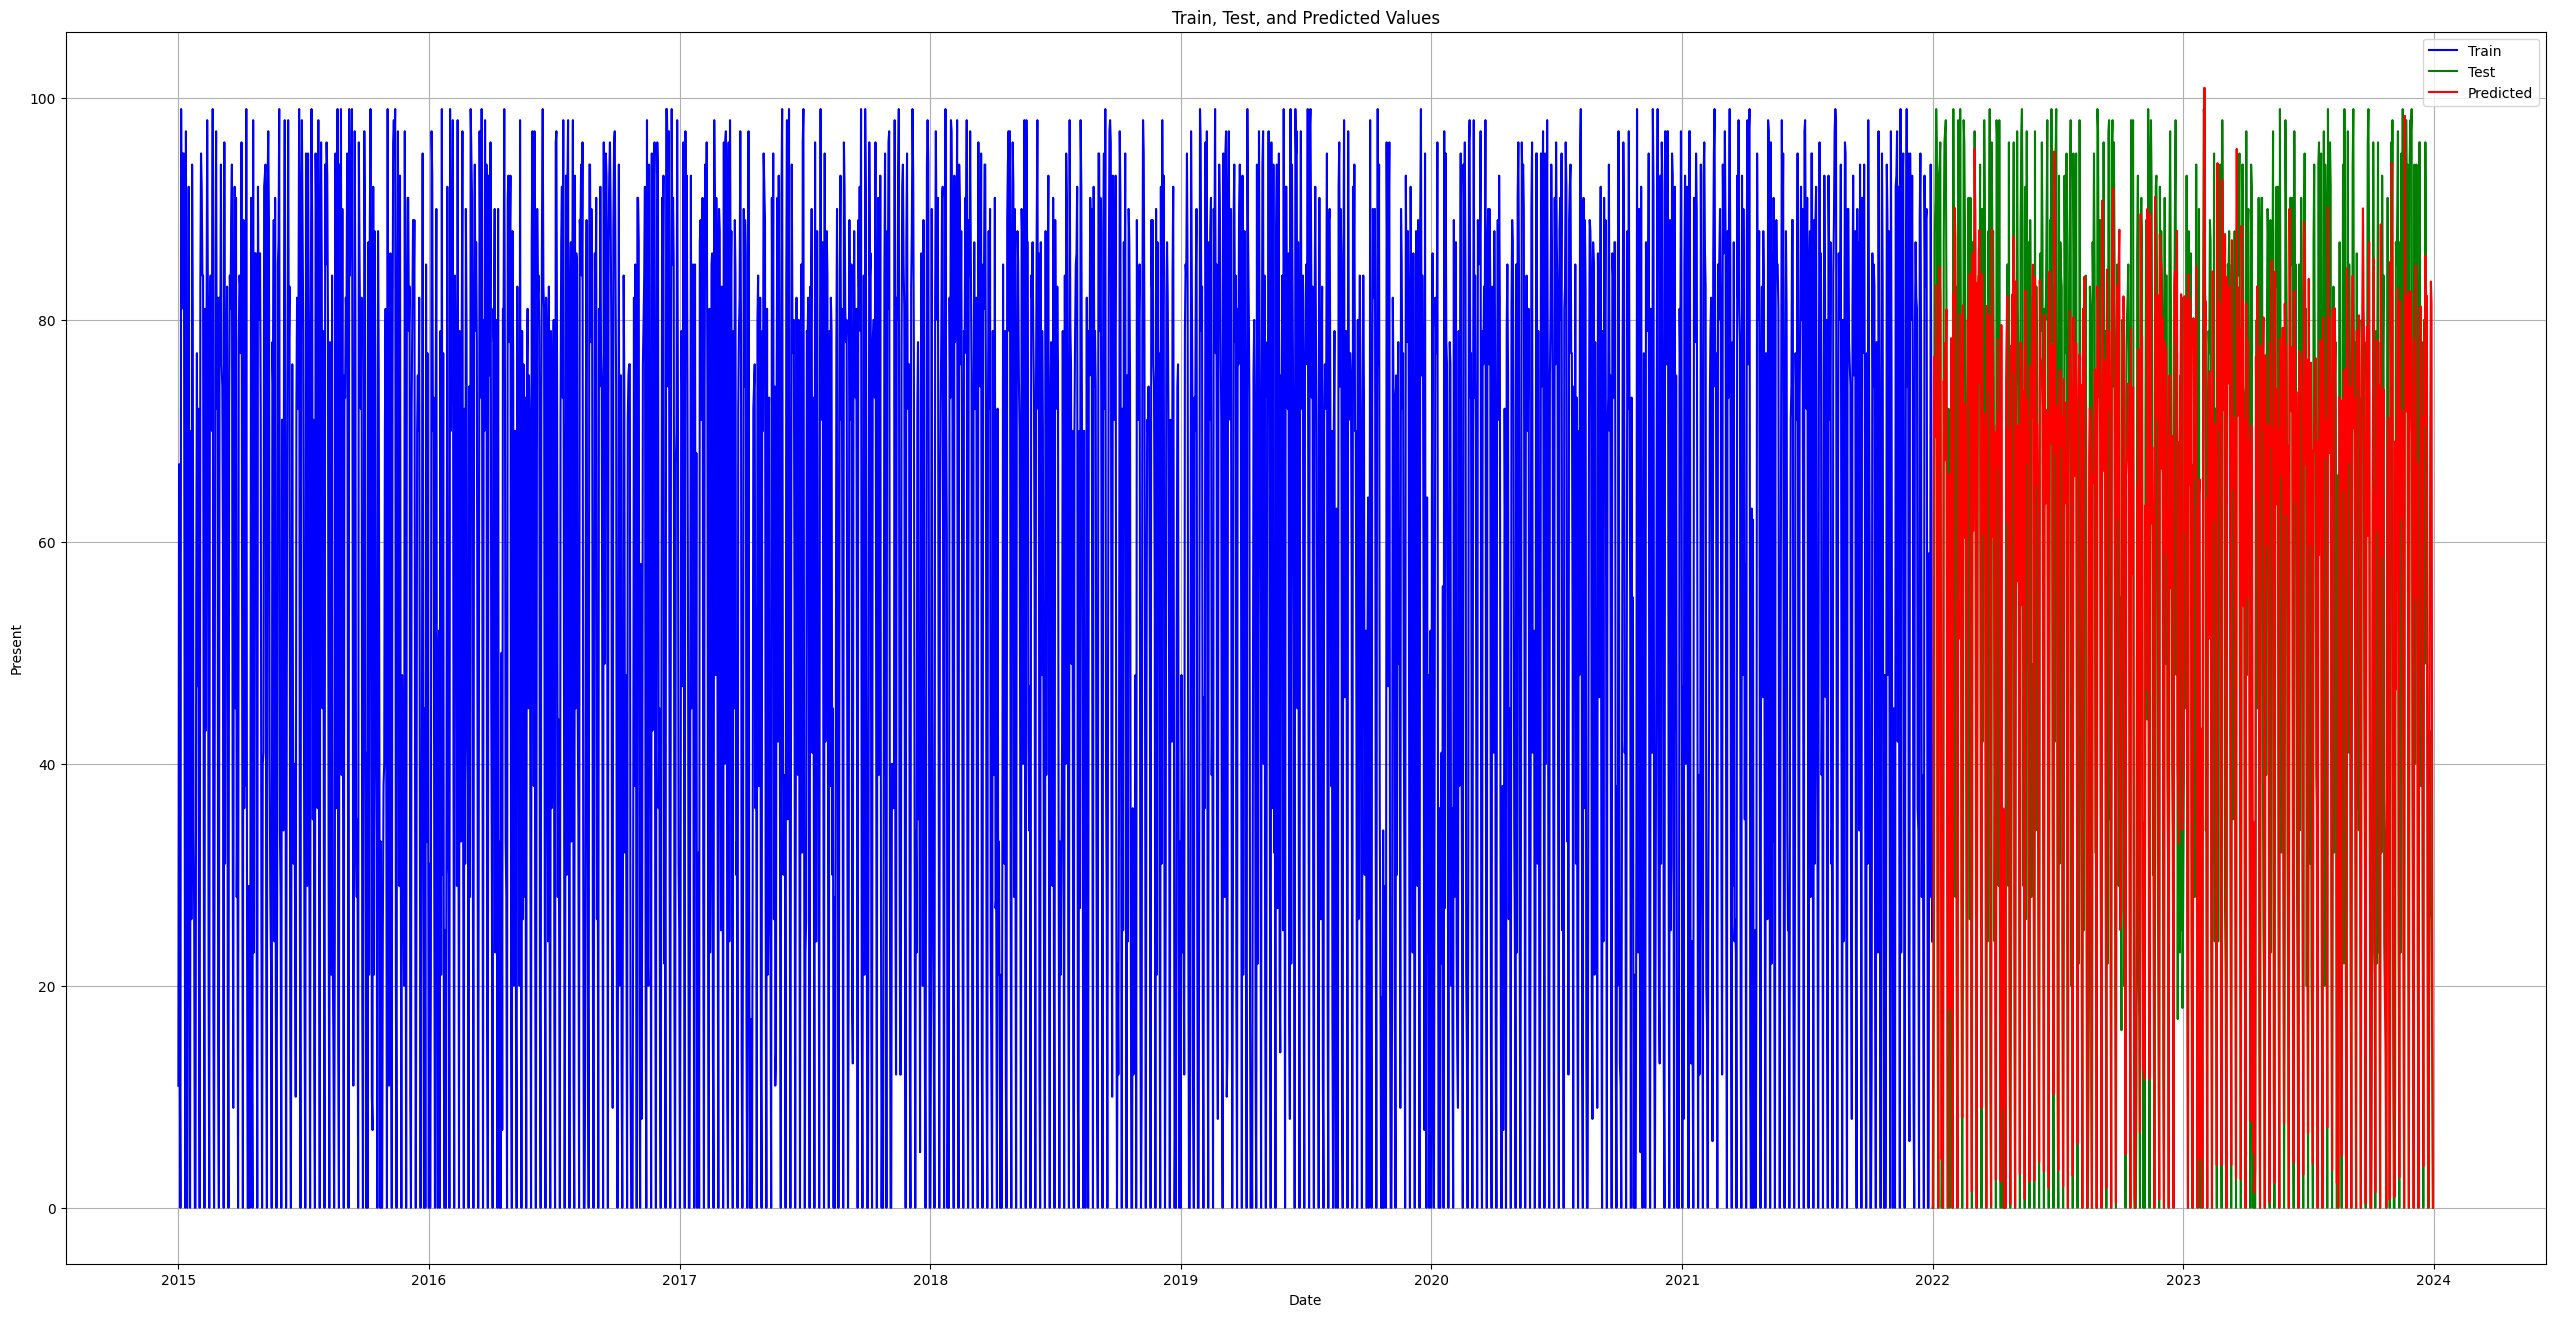

In [ ]:
# Assuming 'Date' is the column containing dates in train_df and test_df
train_dates = train_df['Date']
test_dates = test_df['Date']

# ... (your existing code) ...

# Plotting
fig, ax = plt.subplots(figsize=(32, 16))  # Increased figure size

# Plot training data
ax.plot(train_dates, y_train, label='Train', color='blue')

# Plot testing data
ax.plot(test_dates, y_val, label='Test', color='green')

# Plot predicted data
ax.plot(test_dates, test_predictions, label='Predicted', color='red')

ax.set_xlabel('Date')
ax.set_ylabel('Present')
ax.set_title('Train, Test, and Predicted Values')
ax.legend()
ax.grid(True)
plt.show()



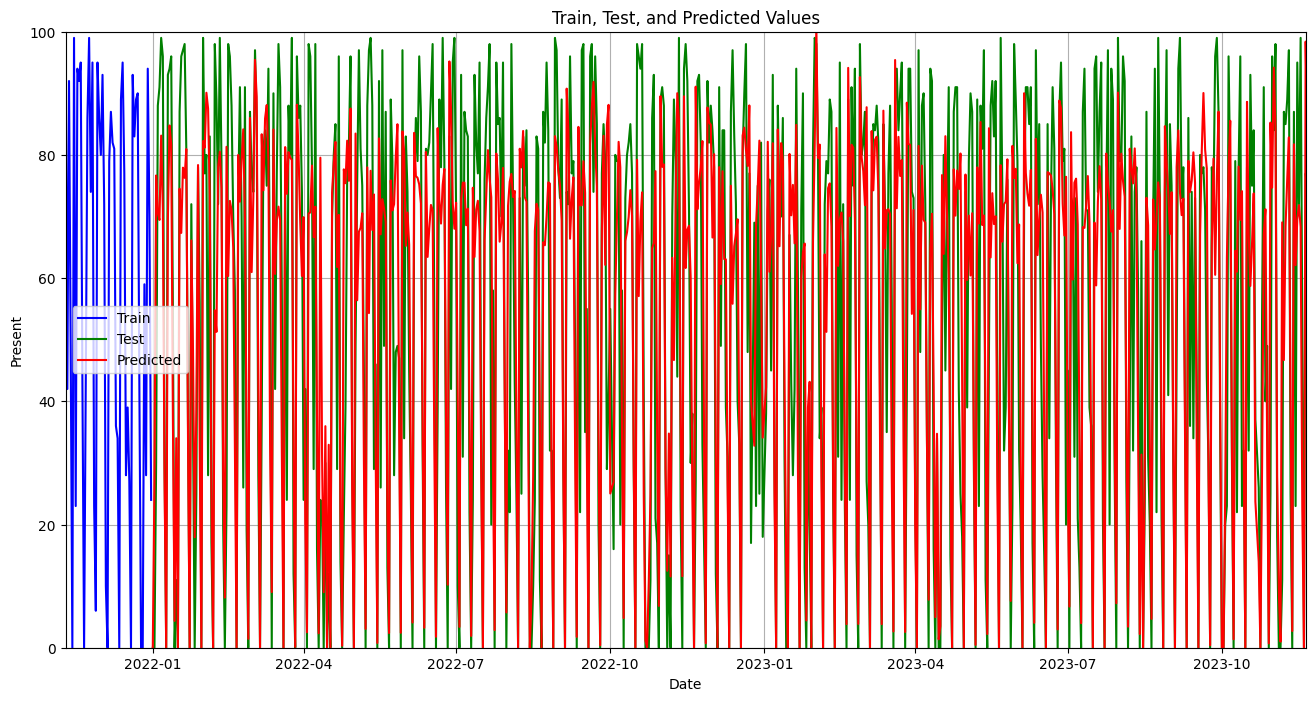

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(16, 8))  # Increased figure size

# Plot training data
ax.plot(train_dates, y_train, label='Train', color='blue')

# Plot testing data
ax.plot(test_dates, y_val, label='Test', color='green')

# Plot predicted data
ax.plot(test_dates, test_predictions, label='Predicted', color='red')

ax.set_xlabel('Date')
ax.set_ylabel('Present')
ax.set_title('Train, Test, and Predicted Values')
ax.legend()
ax.grid(True)
# Zoom in on the test data region
# You might need to adjust these values based on your specific data
ax.set_xlim([pd.to_datetime('2021-11-10'), pd.to_datetime('2023-11-20')])
# Adjust the y-axis limits to encompass the relevant values for the zoomed region
min_y = min(y_val.min(), test_predictions.min())
max_y = max(y_val.max(), test_predictions.max())
ax.set_ylim([min_y, 100])  # Add some padding to the y-axis limits

plt.show()

In [ ]:
n=3
d="2024-03-01"
date_c=pd.to_datetime(d)
df_=create_date_dataframe(d,n)
pre_process_data(df_)
df=create_date_dataframe(d,n+2)
pre_process_data(df)
forecast=xgb_model.predict(df[features])
forecast_round=np.floor(forecast)
submission = pd.DataFrame({
    'Date': df['Date'],
    'Present': forecast_round.astype(int)
})

print(submission)
cumulative_sum = 0
target_sum = df_['Total'].sum()
target_date = None  # Initialize the target date

for index, row in submission.iterrows():
    cumulative_sum += row['Present']
    if cumulative_sum >= target_sum:
        target_date = row['Date']
        break  # Exit the loop once the target sum is reached

print(f"The cumulative sum reaches {cumulative_sum} on {target_date}")



          Date  Present
0   2024-03-01       79
1   2024-03-02       18
2   2024-03-03        0
3   2024-03-04       79
4   2024-03-05       74
..         ...      ...
149 2024-07-28       -6
150 2024-07-29       91
151 2024-07-30       85
152 2024-07-31       82
153 2024-08-01       80

[154 rows x 2 columns]
The cumulative sum reaches 8021 on 2024-07-19 00:00:00


Enter the month: 3
Enter the year: 2023


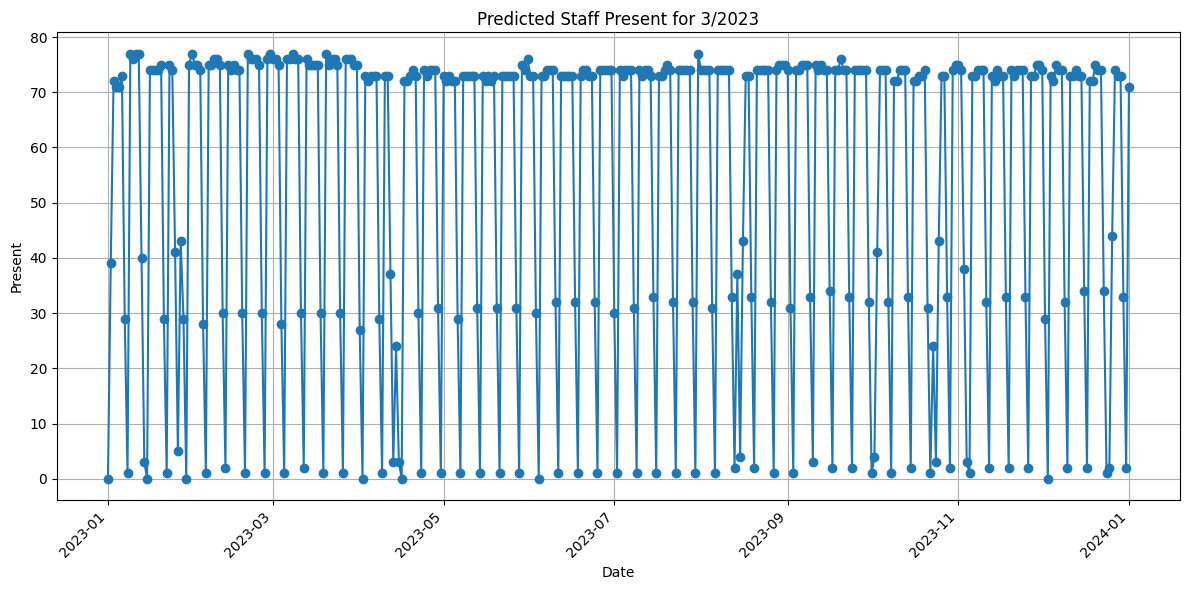

          Date  Present
0   2023-01-01        0
1   2023-01-02       39
2   2023-01-03       72
3   2023-01-04       71
4   2023-01-05       71
..         ...      ...
361 2023-12-28       73
362 2023-12-29       73
363 2023-12-30       33
364 2023-12-31        2
365 2024-01-01       71

[366 rows x 2 columns]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.patches as mpatches
import datetime
def create_month_dataframe(year, month):
    # Get the first and last day of the month
    first_day = datetime.date(year, 1, 1)
    #if month == 12:
        #last_day = datetime.date(year + 1, 1, 1) - datetime.timedelta(days=1)
    #else:
    last_day = datetime.date(year+1, 1, 1)

    # Generate a list of dates and format them
    dates = pd.date_range(start=first_day, end=last_day).strftime('%Y-%m-%d').tolist()

    # Create a DataFrame
    df = pd.DataFrame({'Date': dates})
    return df
# MONTHLY ANALYSIS
input_month = int(input("Enter the month: "))
input_year = int(input("Enter the year: "))
date_df_t = create_month_dataframe(input_year, input_month)
pre_process_data(date_df_t)
forecast=xgb_model.predict(date_df_t[features])
forecast_round=np.floor(forecast)
submission = pd.DataFrame({
    'Date': date_df_t['Date'],
    'Present': forecast_round.astype(int)
})
# Convert 'Date' column to datetime for plotting
submission['Date'] = pd.to_datetime(submission['Date'], format='%d-%m-%Y')

# Plotting the submission DataFrame
plt.figure(figsize=(12, 6))
plt.plot(submission['Date'], submission['Present'],marker='o')
plt.title(f'Predicted Staff Present for {input_month}/{input_year}')
plt.xlabel('Date')
plt.ylabel('Present')
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()
print(submission)